## Imports

In [1]:
import numpy as np
import pandas as pd
from typing import Literal

In [2]:
from google.colab import files
uploaded = files.upload()

Saving marksheet.csv to marksheet.csv


In [3]:
from google.colab import files
uploaded = files.upload()

Saving PI-CAI_labels to PI-CAI_labels


In [4]:
from google.colab import files
uploaded = files.upload()

Saving PI-CAI_features to PI-CAI_features


## Data Reader (!IMPORTANT!)

In [5]:
def is_single_string(param):
    return isinstance(param, str)

def is_list_of_strings(param):
    return isinstance(param, (list, tuple)) and all(isinstance(item, str) for item in param)

In [6]:
def no_polyjuice_getter(sequence, dataset):
    # Filter the dataset to include only AI annotations and selected sequences and ROI lesion
    filtered_dataset = dataset[dataset['annotator'] == 'AI']
    filtered_dataset = filtered_dataset[filtered_dataset['sequence'] == sequence]
    filtered_dataset = filtered_dataset[filtered_dataset['ROI'] == 'lesion']
    filtered_dataset.drop(columns=['annotator', 'sequence', 'ROI_ID', 'ROI','img_path', 'seg_path', 'extraction_ID'], inplace=True)
    dataset = filtered_dataset

    return dataset

In [7]:
def polyjuice_getter(sequence, dataset):
    polyjuice_dataset = None
    filtered_dataset = dataset[dataset['annotator'] == 'AI']
    filtered_dataset = filtered_dataset[filtered_dataset['ROI'] == 'lesion']
    filtered_dataset.drop(columns=['annotator', 'ROI_ID', 'ROI','img_path', 'seg_path', 'extraction_ID'], inplace=True)

    for index, s in enumerate(sequence):
        s_dataset = filtered_dataset[filtered_dataset['sequence'] == s]
        s_dataset = s_dataset.drop(columns=['sequence'])
        for col in s_dataset.columns:
            if col != 'patient_ID' and col != 'study_ID':
                s_dataset = s_dataset.rename(columns={col : str(col + '_' + s)})
        if index == 0:
            polyjuice_dataset = s_dataset
        else:
            polyjuice_dataset = pd.merge(polyjuice_dataset, s_dataset, on=['patient_ID', 'study_ID'], how='inner')

    return polyjuice_dataset

In [8]:
SingleSequence = Literal['t2w', 'adc', 'hbv']


def get_data(sequence : SingleSequence | str | list[str], isup_class1 : list[int] = [0, 1, 2], isup_class2 : list[int] = [3, 4, 5], corr_cutoff=0.9):
    '''
    @param squence : What sequence do you want to study. A list of multiple sequence will also work!
    @param isup_class1 : What ISUP values do you want in the first class
    @param isup_class2 : What ISUP values do you want in the second class
    @param corr_cutoff : The value to cutoff high correlated features

    @return pd.DataFrame : a new columns 'is_class1' is added, specofing if the row is in class1

    Please read the code and the comments, especially the one at the bottom! Some unwanted columns may still be present
    '''

    is_polyjuice = None
    if is_list_of_strings(sequence):
        # Is a vector and not a string
        if len(sequence) > 1:
            # Len > 1 so we are in a polyjuice (mix)
            is_polyjuice = True
        else:
            is_polyjuice = False
    else:
        is_polyjuice = False

    labels = pd.read_csv('marksheet.csv')
    dataset = pd.read_csv('PI-CAI_features')

    new_dataset = None
    if is_polyjuice == False:
        new_dataset = no_polyjuice_getter(sequence, dataset)
    else:
        new_dataset = polyjuice_getter(sequence, dataset)


    # The commented code below was an assumption requested in earlier version of this code, just uncomment if needed
    # We only want Magnetic Resonace Biopsy (MRBx) labels because Systematic Biopsy (SBx) labels are not for our usecase
    # we also remove those that have both because clicinians result might be biased
    #labels = labels[labels['histopath_type'] == 'MRBx']


    labels.rename(columns={'patient_id': 'patient_ID', 'study_id': 'study_ID'}, inplace=True)
    labels.drop(columns=['mri_date', 'histopath_type', 'center', 'lesion_ISUP', 'lesion_GS'], inplace=True)


    # Remove high correlated features
    corr_matrix = new_dataset.drop(columns=['study_ID', 'patient_ID']).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_cutoff)]
    new_dataset.drop(to_drop, axis=1, inplace=True)


    # Drop missing values, perhaps a better way might be useful. What about KNNImputer? If so, maybe checking that we don't miss much values before imputing new ones
    labels.dropna(inplace=True)

    # Rename Yes to 1 and No to 0 in the labels dataset
    labels.case_csPCa = labels.case_csPCa.map(lambda x: 1 if x == 'YES' else 0)      # Is this line really useful??? Maybe we just need to drop this column

    merge = pd.merge(new_dataset, labels, on=['patient_ID', 'study_ID'], how='inner')
    merge.drop(columns=['patient_ID', 'study_ID'], inplace=True)

    isup = 'case_ISUP'


    if sum(isup_class1 + isup_class2) == 15 and len(isup_class1 + isup_class2) == 6:
        # class1 and class2 contains all possible values (from 0 to 5)
        merge['is_class1'] = merge[isup].map(lambda x: 1 if x in isup_class1 else 0)
    else:
        # class1 and class2 don't contain all possible values, so we need to drop some
        merge = merge[merge[isup].isin(isup_class1 + isup_class2)]
        merge['is_class1'] = merge[isup].map(lambda x: 1 if x in isup_class1 else 0)

    # IMPORTANT, README
    # Probably we need to drop case_ISUP and case_csPCa


    return merge



In [9]:
edited = get_data(['t2w', 'adc'])

edited['is_class1']

,is_class1
0,0
1,0
2,1
3,1
4,1
...,...
276,0
277,0
278,1
279,1


In [10]:
print(edited.shape[1])

618


In [11]:
def clean_data(data : pd.DataFrame, corr_cutoff : float = 0.9):
    corr = data.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_cutoff)]
    clean = data.copy()
    clean.drop(to_drop, axis=1, inplace=True)


    return clean

## ELIMINAZIONE VARIABILI CON CORRELAZIONE > DI 0,9

In [12]:
X = edited.drop(columns=['case_ISUP', 'is_class1'])
y = edited['is_class1']

# Rimuovi feature altamente correlate
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
X = X.drop(columns=to_drop)

print("Feature rimosse:", to_drop)


Feature rimosse: ['original_shape_MeshVolume_t2w', 'log-sigma-3-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis_t2w', 'log-sigma-3-0-mm-3D_gldm_SmallDependenceLowGrayLevelEmphasis_t2w', 'wavelet-LLH_glrlm_LongRunEmphasis_t2w', 'wavelet-LHL_glszm_LargeAreaEmphasis_t2w', 'wavelet-LHH_glszm_LargeAreaEmphasis_t2w', 'wavelet-HLH_firstorder_InterquartileRange_t2w', 'wavelet-HHL_glszm_LargeAreaHighGrayLevelEmphasis_t2w', 'original_ngtdm_Contrast_adc', 'log-sigma-5-0-mm-3D_firstorder_Mean_adc', 'log-sigma-5-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis_adc', 'wavelet-LLH_firstorder_RootMeanSquared_adc', 'wavelet-LLH_glcm_Imc2_adc', 'wavelet-LHL_glrlm_LongRunEmphasis_adc', 'wavelet-LHH_glszm_LargeAreaEmphasis_adc', 'wavelet-LHH_glszm_LargeAreaLowGrayLevelEmphasis_adc', 'wavelet-HLH_glszm_LargeAreaHighGrayLevelEmphasis_adc', 'wavelet-HHL_glcm_Imc2_adc', 'wavelet-HHL_glszm_LargeAreaEmphasis_adc', 'wavelet-HHL_glszm_LargeAreaHighGrayLevelEmphasis_adc', 'wavelet-HHL_glszm_LargeAreaLowGrayLevelEmphasis_

In [13]:
print(X.shape[1])

593


# MODELLI PER ISUP 2 O 3

In [14]:
# Filter the existing 'edited' DataFrame
edited = edited[edited['case_ISUP'].isin([2, 3])].copy()
edited['is_class1'] = edited['case_ISUP'].map(lambda x: 1 if x == 3 else 0)

In [15]:
count_2 = (edited['case_ISUP'] == 2).sum()
count_3 = (edited['case_ISUP'] == 3).sum()

print("Valori 2:", count_2)
print("Valori 3:", count_3)

Valori 2: 144
Valori 3: 70


In [16]:
print("Numero di colonne:", edited.shape[1])

Numero di colonne: 618


In [17]:
print("Numero di righe:", edited.shape[0])

Numero di righe: 214


In [18]:
print(edited.dtypes)

original_shape_Elongation_t2w                 float64
original_shape_Flatness_t2w                   float64
original_shape_LeastAxisLength_t2w            float64
original_shape_MajorAxisLength_t2w            float64
original_shape_Maximum2DDiameterColumn_t2w    float64
                                               ...   
psad                                          float64
prostate_volume                               float64
case_ISUP                                       int64
case_csPCa                                      int64
is_class1                                       int64
Length: 618, dtype: object


# AUMENTO NUMERO RIGHE


Per migliorare l’addestramento del modello, ho effettuato data augmentation sul training set. Ho generato nuove righe aggiungendo un piccolo rumore ai dati originali, in modo da simulare variazioni realistiche. Così ho triplicato la dimensione del training set facendo IL TRAINING-TEST SPLIT prima. L’etichetta è rimasta la stessa, e il test set non è mai stato toccato, quindi le valutazioni del modello sono affidabili e non affette da overfitting o data leakage.

In [19]:
print("Colonne in edited:", edited.shape[1])
print("Colonne in X:", X.shape[1])
print("Nomi colonne:", X.columns.tolist())

Colonne in edited: 618
Colonne in X: 593
Nomi colonne: ['original_shape_Elongation_t2w', 'original_shape_Flatness_t2w', 'original_shape_LeastAxisLength_t2w', 'original_shape_MajorAxisLength_t2w', 'original_shape_Maximum2DDiameterColumn_t2w', 'original_shape_Maximum2DDiameterRow_t2w', 'original_shape_Maximum2DDiameterSlice_t2w', 'original_shape_Sphericity_t2w', 'original_shape_SurfaceVolumeRatio_t2w', 'original_firstorder_10Percentile_t2w', 'original_firstorder_90Percentile_t2w', 'original_firstorder_Entropy_t2w', 'original_firstorder_InterquartileRange_t2w', 'original_firstorder_Kurtosis_t2w', 'original_firstorder_Maximum_t2w', 'original_firstorder_Minimum_t2w', 'original_firstorder_Skewness_t2w', 'original_glcm_Autocorrelation_t2w', 'original_glcm_ClusterProminence_t2w', 'original_glcm_Contrast_t2w', 'original_glcm_Correlation_t2w', 'original_glcm_JointEnergy_t2w', 'original_glcm_Imc2_t2w', 'original_glcm_Idm_t2w', 'original_glcm_Idmn_t2w', 'original_glrlm_LongRunEmphasis_t2w', 'origi

AUMENTO SOLO LA CLASSE 1 (ISUP 3 ) COSI SONO BILANCIATE

In [20]:

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

#  Creo X e y
X = edited.drop(columns=['case_ISUP', 'is_class1'])  # Feature set
y = edited['is_class1']  # Target binario

#  Train/test split stratificato
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# AUGMENTO SOLO LA CLASSE 1 NEL TRAIN SET
np.random.seed(42)

X_class1 = X_train[y_train == 1]
y_class1 = y_train[y_train == 1]

col_std = X_class1.std()

num_copies = 1
augmented_list = []

for i in range(num_copies):
    sampled = X_class1.sample(frac=1.0, replace=True, random_state=42 + i)
    noise = np.random.normal(loc=0, scale=col_std.values * 0.05, size=sampled.shape)
    noisy = sampled + noise
    noisy = pd.DataFrame(noisy, columns=X_train.columns).clip(lower=0)
    augmented_list.append(noisy)

X_train_aug = pd.concat([X_train] + augmented_list, ignore_index=True)
y_train_aug = pd.concat([y_train] + [y_class1] * num_copies, ignore_index=True)


print("Distribuzione dopo augmentation:")
print(y_train_aug.value_counts())
print("Shape:", X_train_aug.shape)


Distribuzione dopo augmentation:
is_class1
0    115
1    112
Name: count, dtype: int64
Shape: (227, 616)


In [21]:
print("Numero di righe e colonne:", X_train_aug.shape)

Numero di righe e colonne: (227, 616)


# SELEZIONE FEATURE

# SELEZIONE FEATURE SU X_train_aug
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

# 1. Rimuove feature a bassa varianza
vt = VarianceThreshold(threshold=0.01)
X_var = vt.fit_transform(X_train_aug)
X_var = pd.DataFrame(X_var, columns=X_train_aug.columns[vt.get_support()])

# 2. Rimuove feature troppo correlate
corr_matrix = X_var.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
X_uncorr = X_var.drop(columns=to_drop)

# 3. Selezione feature più importanti con Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_uncorr, y_train_aug)

importances = pd.Series(rf.feature_importances_, index=X_uncorr.columns)
top_features = importances.sort_values(ascending=False).head(30).index
X_selected = X_uncorr[top_features]


In [22]:
# SELEZIONE FEATURE SU X_train_aug
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

# 1. Rimuovo feature a bassa varianza
vt = VarianceThreshold(threshold=0.01)
X_var = vt.fit_transform(X_train_aug)
X_var = pd.DataFrame(X_var, columns=X_train_aug.columns[vt.get_support()])

# 2. Rimuovo feature troppo correlate
corr_matrix = X_var.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
X_uncorr = X_var.drop(columns=to_drop)

# 3. Selezione feature più importanti con Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_uncorr, y_train_aug)

importances = pd.Series(rf.feature_importances_, index=X_uncorr.columns)
top_features = importances.sort_values(ascending=False).head(30).index
X_selected = X_uncorr[top_features]



In [23]:
print("Numero di righe e colonne:", top_features.shape)

Numero di righe e colonne: (30,)


In [24]:
print(X.dtypes.value_counts())

float64    614
int64        2
Name: count, dtype: int64


## Random forest df aumentato

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# Seleziono solo le 30 feature più importanti dai dati aumentati
X_train_sel = X_train_aug[top_features]
X_test_sel = X_test[top_features]

# Standardizzazione
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

# Random Forest base
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Spazio degli iperparametri
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit con i dati aumentati e selezionati
random_search.fit(X_train_scaled, y_train_aug)

# Predizione sul test set
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_scaled)


print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
Accuracy: 0.6976744186046512
Precision: 0.5714285714285714
Recall: 0.2857142857142857
F1 Score: 0.38095238095238093


In [26]:
from sklearn.metrics import classification_report

# Predizioni sul test set
y_pred = best_rf.predict(X_test_scaled)

# Report completo per ciascuna classe
report = classification_report(y_test, y_pred, target_names=["Classe 0 (ISUP 2)", "Classe 1 (ISUP 3)"])
print(report)


                   precision    recall  f1-score   support

Classe 0 (ISUP 2)       0.72      0.90      0.80        29
Classe 1 (ISUP 3)       0.57      0.29      0.38        14

         accuracy                           0.70        43
        macro avg       0.65      0.59      0.59        43
     weighted avg       0.67      0.70      0.66        43



IL MODELLO IDENTIFICA BENE I CASI MENO GRAVI MA NON RIESCE QUSI MAI (1 SU 3) A IDENTIFICARE QUELLI PIU GRAVI

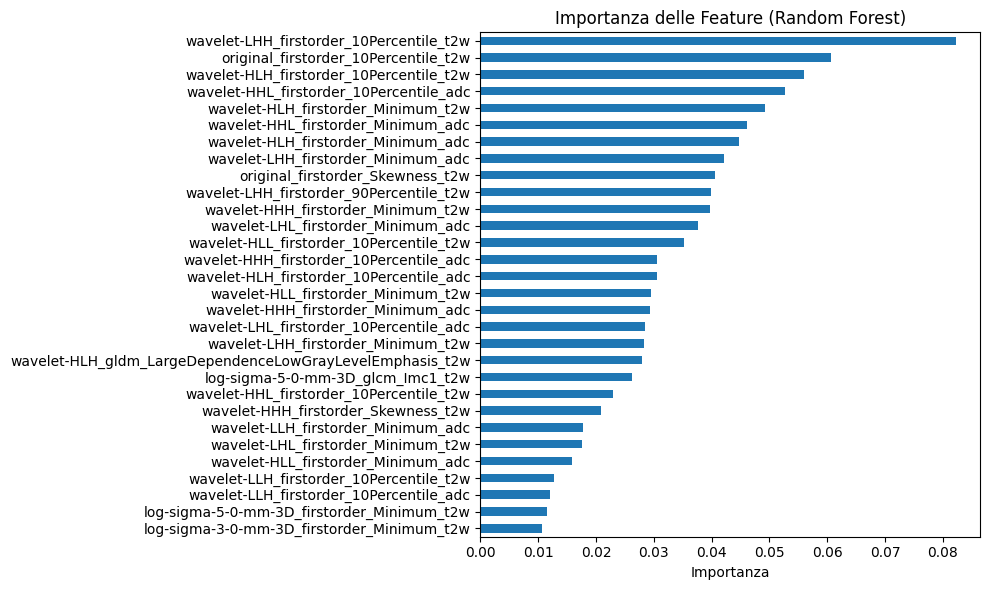

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Recupera i nomi delle feature DAL DATASET SU CUI IL MODELLO È STATO ADDESTRATO
# Usa X_test_scaled che contiene solo le feature selezionate da top_features
feature_names = X_test_sel.columns # Utilizza le colonne del dataframe selezionato

# Importanza dal modello
importances = best_rf.feature_importances_

# Visualizzazione
# Assicurati che le importances corrispondano alle feature_names selezionate
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feat_imp.plot(kind='barh')
plt.title("Importanza delle Feature (Random Forest)")
plt.xlabel("Importanza")
plt.tight_layout()
plt.show()


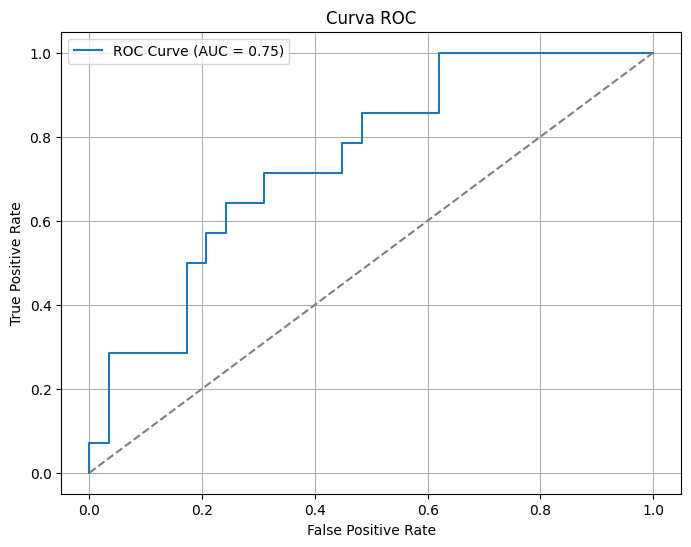

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score

# Probabilità predette (non le classi)
y_proba = best_rf.predict_proba(X_test_scaled)[:, 1]  # solo la colonna positiva

# Curve ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()


<Figure size 600x600 with 0 Axes>

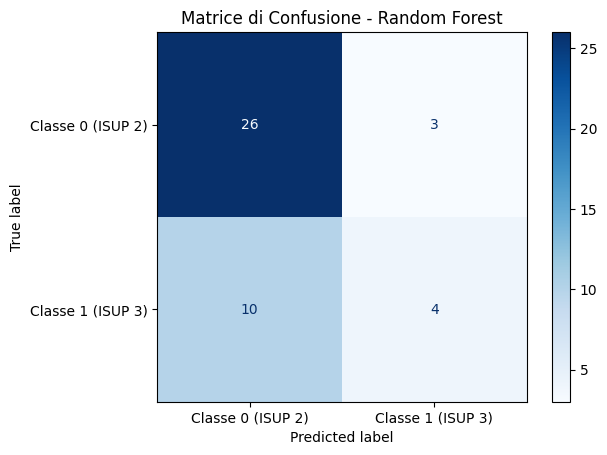

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predizioni sul test set
y_pred = best_rf.predict(X_test_scaled)

# Calcolo della matrice di confusione
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Classe 0 (ISUP 2)", "Classe 1 (ISUP 3)"])

# Visualizzazione
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice di Confusione - Random Forest")
plt.grid(False)
plt.show()

Le top feature della Random Forest sono ottime per distinguere bene i casi “meno gravi” (ISUP 2),
ma non sono sufficienti per individuare i casi gravi (ISUP 3).

# SHAP

Faccio uno shap solo sulla classe 0 cioè Isup 2 perchè è solo per quella classe che le variabili selezionate dalla random sono predittive

In [40]:
!pip install shap

<ipython-input-45-e6f70724e5e8>:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[idx_isup2, :, 0], X_test_df.iloc[idx_isup2])


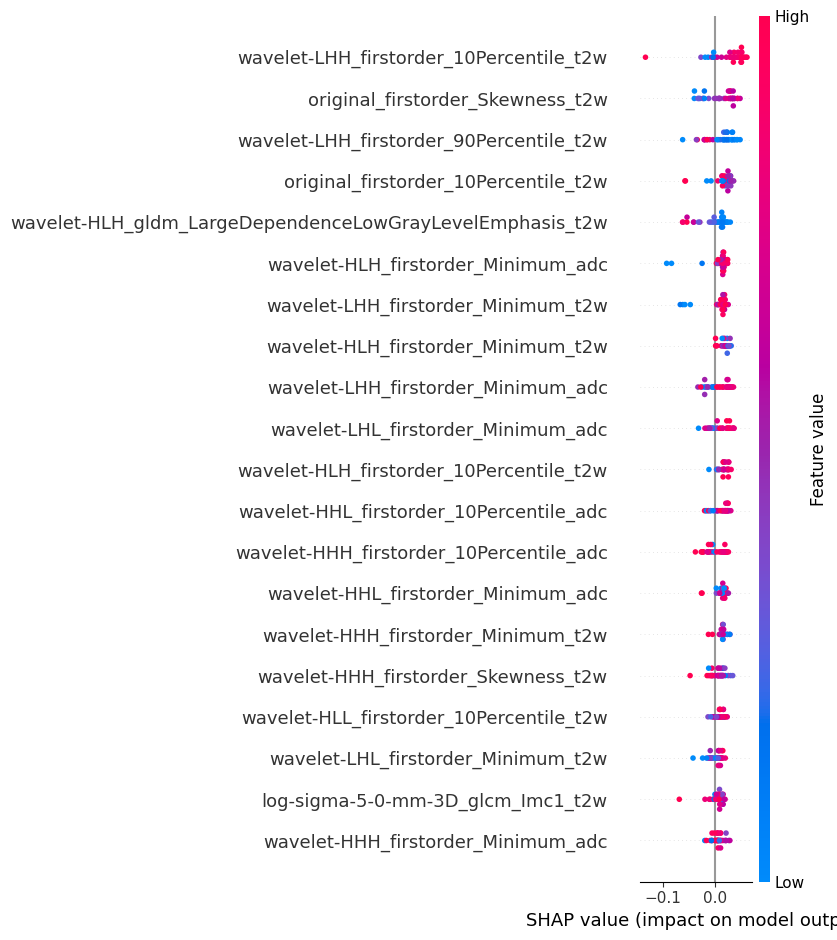

In [45]:
import shap
import pandas as pd
import numpy as np

# Fit del modello sul training set completo (se non già fatto)
best_rf.fit(X_train_scaled, y_train_aug)

# Crea l'explainer SHAP
explainer = shap.TreeExplainer(best_rf)

# Calcola i valori SHAP sul test set
# For binary classification with a (n_samples, n_features, n_classes) output,
# shap_values[:, :, 0] are the values for class 0.
# We calculate SHAP values for the entire test set first
shap_values = explainer.shap_values(X_test_scaled)

# Converte il test set in DataFrame per avere i nomi delle feature
X_test_df = pd.DataFrame(X_test_scaled, columns=top_features)

# Get the predicted classes for the test set
y_pred = best_rf.predict(X_test_scaled) # Ensure y_pred is available from the previous step

# Filtra solo i campioni predetti come Classe 0 (ISUP 2)
idx_isup2 = np.where(y_pred == 0)[0]

# Plot SHAP solo per Classe 0 (ISUP 2), campioni predetti come tali
# Select SHAP values for class 0 (index 0 on the last axis) for the filtered samples
# The correct slicing for a (samples, features, classes) array is [sample_indices, :, class_index]
shap.summary_plot(shap_values[idx_isup2, :, 0], X_test_df.iloc[idx_isup2])




## Xgboost df aumentato

In [46]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_dist_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_xgb.fit(X_train_scaled, y_train_aug)
best_xgb = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)

print("Best XGBoost Parameters:", random_search_xgb.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:21:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Accuracy: 0.7441860465116279
Precision: 0.7142857142857143
Recall: 0.35714285714285715
F1 Score: 0.47619047619047616


In [47]:
from sklearn.metrics import classification_report

# Predizioni XGBoost
y_pred_xgb = best_xgb.predict(X_test_scaled)

# Report completo
report_xgb = classification_report(y_test, y_pred_xgb, target_names=["Classe 0 (ISUP 2)", "Classe 1 (ISUP 3)"])
print(report_xgb)



                   precision    recall  f1-score   support

Classe 0 (ISUP 2)       0.75      0.93      0.83        29
Classe 1 (ISUP 3)       0.71      0.36      0.48        14

         accuracy                           0.74        43
        macro avg       0.73      0.64      0.65        43
     weighted avg       0.74      0.74      0.72        43



<Figure size 600x600 with 0 Axes>

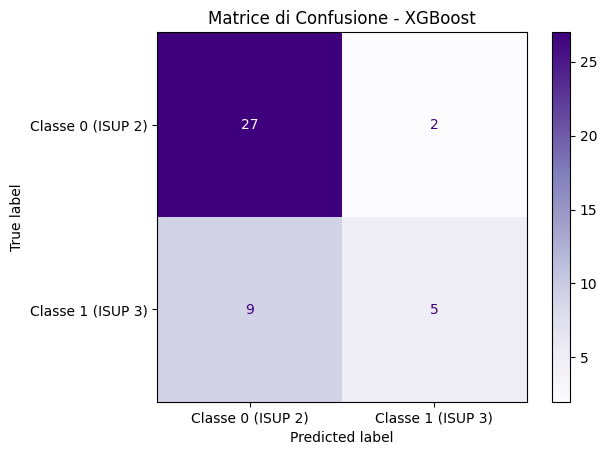

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predizioni XGBoost
y_pred_xgb = best_xgb.predict(X_test_scaled)

# Matrice di confusione
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["Classe 0 (ISUP 2)", "Classe 1 (ISUP 3)"])

# Visualizzazione
plt.figure(figsize=(6, 6))
disp_xgb.plot(cmap="Purples", values_format="d")
plt.title("Matrice di Confusione - XGBoost")
plt.grid(False)
plt.show()


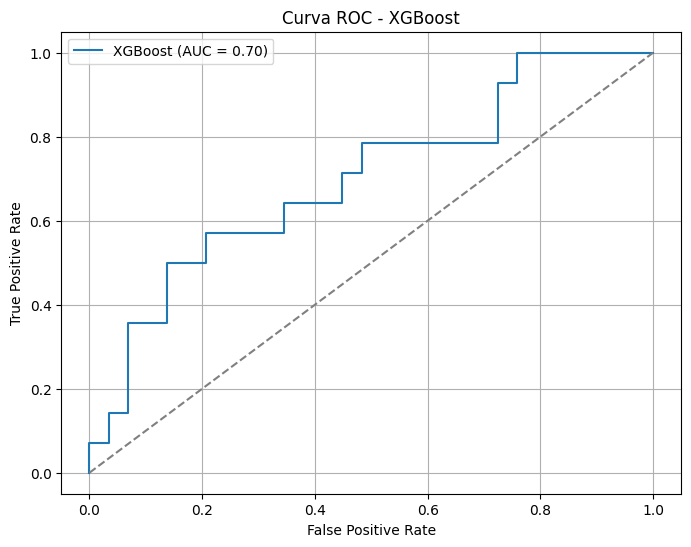

In [49]:
from sklearn.metrics import roc_curve, roc_auc_score

# Probabilità previste
y_proba_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]  # Probabilità della classe 1

# Curve ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - XGBoost')
plt.legend()
plt.grid(True)
plt.show()


## MLP df aumentato

In [50]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=500, random_state=42)

param_dist_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

random_search_mlp = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dist_mlp,
    n_iter=20,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_mlp.fit(X_train_scaled, y_train_aug)
best_mlp = random_search_mlp.best_estimator_
y_pred_mlp = best_mlp.predict(X_test_scaled)

print("Best MLP Parameters:", random_search_mlp.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Precision:", precision_score(y_test, y_pred_mlp))
print("Recall:", recall_score(y_test, y_pred_mlp))
print("F1 Score:", f1_score(y_test, y_pred_mlp))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best MLP Parameters: {'solver': 'adam', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (50, 50), 'alpha': 0.001, 'activation': 'tanh'}
Accuracy: 0.6976744186046512
Precision: 0.5294117647058824
Recall: 0.6428571428571429
F1 Score: 0.5806451612903226


In [51]:
from sklearn.metrics import classification_report

# Predizioni
y_pred_mlp = best_mlp.predict(X_test_scaled)

# Report dettagliato
report_mlp = classification_report(y_test, y_pred_mlp, target_names=["Classe 0 (ISUP 2)", "Classe 1 (ISUP 3)"])
print(report_mlp)


                   precision    recall  f1-score   support

Classe 0 (ISUP 2)       0.81      0.72      0.76        29
Classe 1 (ISUP 3)       0.53      0.64      0.58        14

         accuracy                           0.70        43
        macro avg       0.67      0.68      0.67        43
     weighted avg       0.72      0.70      0.70        43



<Figure size 600x600 with 0 Axes>

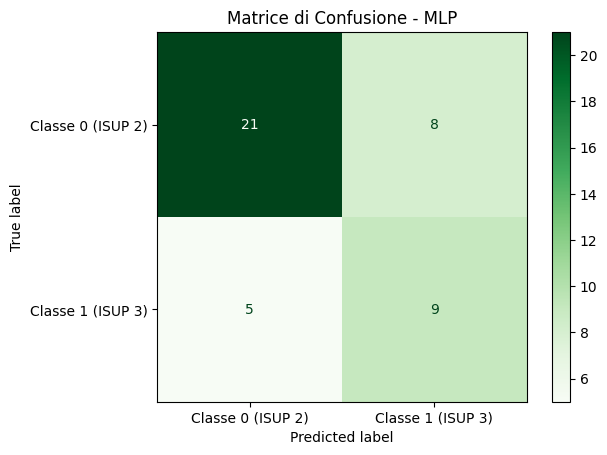

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Matrice di confusione
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=["Classe 0 (ISUP 2)", "Classe 1 (ISUP 3)"])

# Visualizzazione
plt.figure(figsize=(6, 6))
disp_mlp.plot(cmap="Greens", values_format="d")
plt.title("Matrice di Confusione - MLP")
plt.grid(False)
plt.show()


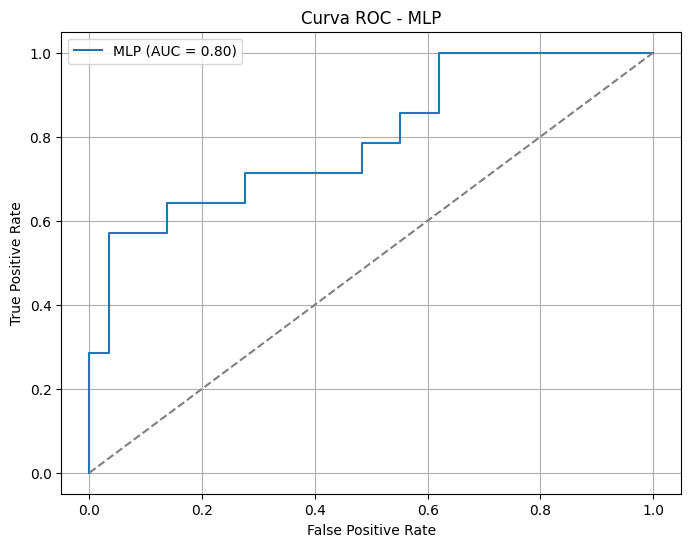

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score

# Probabilità predette (classe positiva)
y_proba_mlp = best_mlp.predict_proba(X_test_scaled)[:, 1]

# ROC Curve
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_proba_mlp)
auc_mlp = roc_auc_score(y_test, y_proba_mlp)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - MLP')
plt.legend()
plt.grid(True)
plt.show()


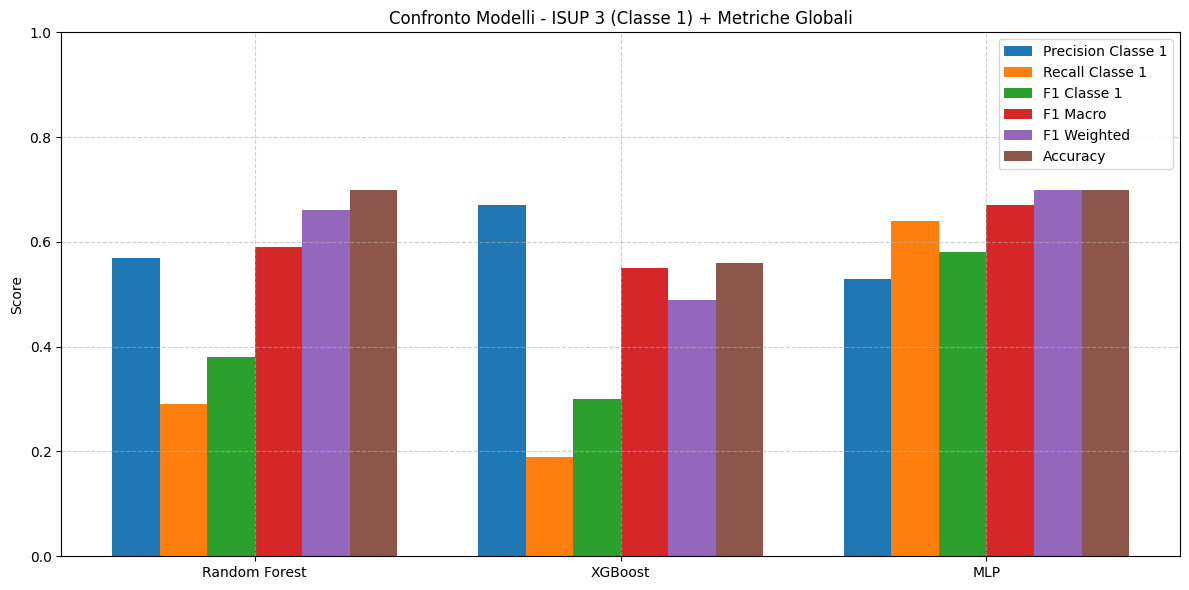

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Dati ricavati dalle 3 classification report (Random Forest, XGBoost, MLP)
data = {
    'Modello': ['Random Forest', 'XGBoost', 'MLP'],
    'Precision Classe 1': [0.57, 0.67, 0.53],
    'Recall Classe 1':    [0.29, 0.19, 0.64],
    'F1 Classe 1':        [0.38, 0.30, 0.58],
    'F1 Macro':           [0.59, 0.55, 0.67],
    'F1 Weighted':        [0.66, 0.49, 0.70],
    'Accuracy':           [0.70, 0.56, 0.70]
}

#  Crea DataFrame
df = pd.DataFrame(data)

#  Metriche da plottare
metrics = ['Precision Classe 1', 'Recall Classe 1', 'F1 Classe 1', 'F1 Macro', 'F1 Weighted', 'Accuracy']
x = np.arange(len(df['Modello']))
width = 0.13

# 📈 Plot
fig, ax = plt.subplots(figsize=(12, 6))

for i, metric in enumerate(metrics):
    ax.bar(x + i * width, df[metric], width, label=metric)

ax.set_ylabel('Score')
ax.set_title('Confronto Modelli - ISUP 3 (Classe 1) + Metriche Globali')
ax.set_xticks(x + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(df['Modello'])
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


L MLP è PIU' BILANCIATO PERO' SE VOGLIAMO PERFORMANCE PER TROVARE I CASI ISUP 2 SONO MEGLIO GLI ALTRI MODELLI CIOE' HANO PERMESSO DI INDIVIDUARE LE VARIABILI CHE PORTANO A ISUP 2